#### LEANDRO BARROS GIMENEZ

# Data Science Small teste

1 - Build a classification problem, using the columns x, y and z, trying to classify the label
column.
#### a) Segregate a test and training frame.
#### b) Use a GLM or Logistic Regression model and show the results.
#### c) Use other method of your choice to handle the problem
#### d) Compare and comment the results on the models used from b) and c)

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.utils.multiclass import unique_labels

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. Carregando o dataset

In [2]:
dfPoints = pd.read_csv("df_points.txt", delimiter="\t")

In [3]:
dfPoints.head()

,Unnamed: 0,x,y,z,label
0,0,326.488285,188.988808,-312.205307,0.0
1,1,-314.287214,307.276723,-179.037412,1.0
2,2,-328.208910,181.627758,446.311062,1.0
3,3,-148.658890,147.027947,-27.477959,1.0
4,4,-467.065931,250.467651,-306.475330,1.0


In [4]:
dfPoints.drop('Unnamed: 0', axis=1, inplace=True)

# 2. Análise Exploratória dos Dados

In [5]:
dfPoints.shape

(10000, 4)

Não existem valores nulos no dataset

In [6]:
dfPoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
x        10000 non-null float64
y        10000 non-null float64
z        10000 non-null float64
label    10000 non-null float64
dtypes: float64(4)
memory usage: 312.6 KB


O dataset está balanceado

In [7]:
dfPoints['label'].value_counts()

1.0    5027
0.0    4973
Name: label, dtype: int64

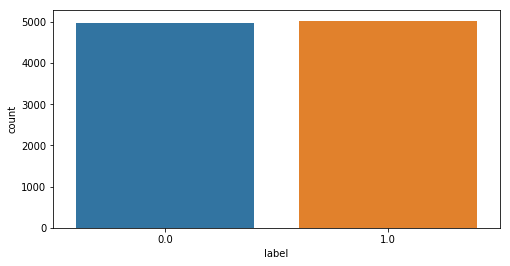

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=dfPoints)#, palette='coolwarm')

In [9]:
dfPoints.describe()

,x,y,z,label
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.850362,-3.108769,-2.601124,0.502700
std,288.379928,287.120263,290.379789,0.500018
min,-499.802348,-499.899134,-499.952571,0.000000
25%,-249.199895,-248.954580,-258.005693,0.000000
50%,3.663472,-5.446168,-8.221000,1.000000
75%,248.879970,244.395864,252.930406,1.000000
max,499.872453,499.752418,499.872329,1.000000


As variáveis possuem distribuições bem parecidas

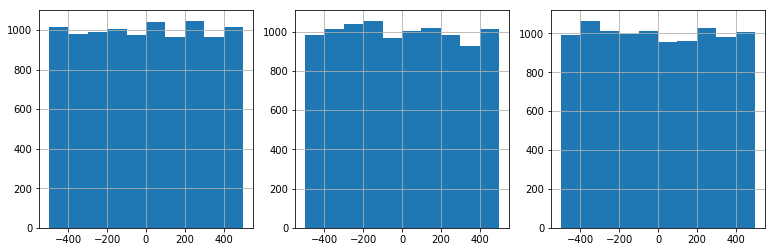

In [10]:
cols = ['x','y','z']

fig, ax = plt.subplots(1, 3, figsize=(13, 4))
for i, c in enumerate(cols):
    dfPoints[c].hist(ax=ax[i])   

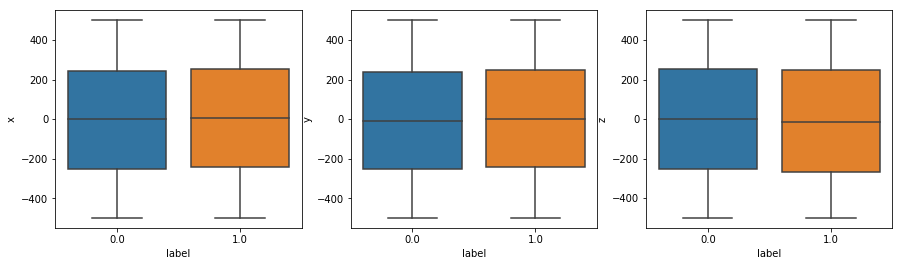

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, c in enumerate(cols):
    sns.boxplot(x='label',y=c,data=dfPoints, ax=ax[i])  

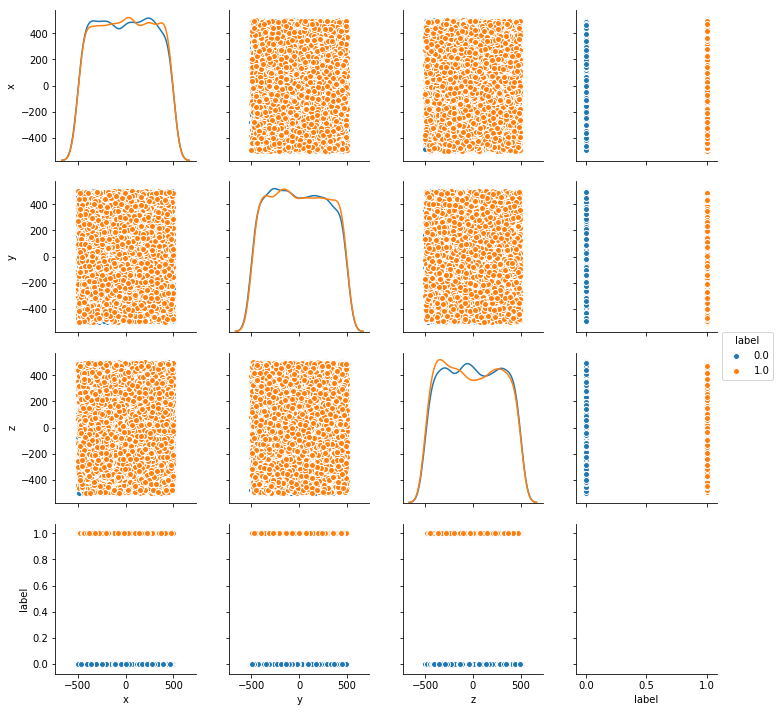

In [12]:
sns.pairplot(dfPoints, hue='label', diag_kind="kde")

A princípio não existe correlação entre as variáveis

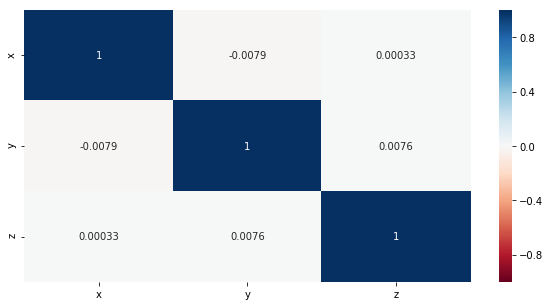

In [13]:
plt.figure(figsize=(10,5))
sns.heatmap(dfPoints.drop(['label'], axis=1).corr(), vmin=-1, cmap='RdBu', annot=True)

# 3. Construção dos modelos

Conforme solicitado, serão criados 2 modelos (Regressão Logística e Random Forest) com validação cruzada a fim de evitar o overfit e com grid search para encontrar os melhores hiper-parâmetros de um determinado range informado.

In [14]:
from sklearn.model_selection import train_test_split

X = dfPoints.drop(['label'], axis=1)
y = dfPoints['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)

In [15]:
def train_grid_search(X_train, y_train, model, parameters, cv):
    
    gs_model = GridSearchCV(model, parameters, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=4)
    gs_model.fit(X_train, y_train)
    print('Melhores parâmetros:')
    print()
    print(gs_model.best_params_)
    print()
    print('Tabela com o resultado dos modelos:')
    print()
    means = gs_model.cv_results_['mean_test_score']
    stds = gs_model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs_model.cv_results_['params']):
        print('{:.3f} (+/-{:.3f}) for {}'.format(mean, std * 2, params))
    print()
    
    return gs_model

In [16]:
def get_results(X_test, y_test, model):
    y_true, y_pred = y_test, model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    from sklearn.metrics import accuracy_score
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print()
    print(classification_report(y_true, y_pred, digits=4))
    print()
        
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test,  y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.xlabel('Curva ROC')
    plt.show()    
    
    df_proba = pd.DataFrame(dict(y_proba = y_proba, y_test = y_test)).reset_index()
    sns.distplot( df_proba[df_proba['y_test']==1]['y_proba'], color="red", label="1")
    sns.distplot( df_proba[df_proba['y_test']==0]['y_proba'], color="skyblue", label="0")
    plt.xlabel('Distribuição de probabilidades')
    plt.legend()    
    

In [17]:
from sklearn.linear_model import LogisticRegression

parameters = {'solver' : ['newton-cg', 'sag', 'saga', 'liblinear', 'lbfgs'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'random_state': [33]}
cv = 3
lr = train_grid_search(X_train, y_train, LogisticRegression(), parameters, cv)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   11.8s finished


Melhores parâmetros:

{'C': 0.001, 'random_state': 33, 'solver': 'saga'}

Tabela com o resultado dos modelos:

0.514 (+/-0.019) for {'C': 0.001, 'random_state': 33, 'solver': 'newton-cg'}
0.514 (+/-0.019) for {'C': 0.001, 'random_state': 33, 'solver': 'sag'}
0.514 (+/-0.019) for {'C': 0.001, 'random_state': 33, 'solver': 'saga'}
0.514 (+/-0.019) for {'C': 0.001, 'random_state': 33, 'solver': 'liblinear'}
0.514 (+/-0.019) for {'C': 0.001, 'random_state': 33, 'solver': 'lbfgs'}
0.514 (+/-0.019) for {'C': 0.01, 'random_state': 33, 'solver': 'newton-cg'}
0.514 (+/-0.019) for {'C': 0.01, 'random_state': 33, 'solver': 'sag'}
0.514 (+/-0.019) for {'C': 0.01, 'random_state': 33, 'solver': 'saga'}
0.514 (+/-0.019) for {'C': 0.01, 'random_state': 33, 'solver': 'liblinear'}
0.514 (+/-0.019) for {'C': 0.01, 'random_state': 33, 'solver': 'lbfgs'}
0.514 (+/-0.019) for {'C': 0.1, 'random_state': 33, 'solver': 'newton-cg'}
0.514 (+/-0.019) for {'C': 0.1, 'random_state': 33, 'solver': 'sag'}
0.514 (+/-

Accuracy:  0.569

             precision    recall  f1-score   support

        0.0     0.5699    0.5447    0.5570       995
        1.0     0.5682    0.5930    0.5803      1005

avg / total     0.5690    0.5690    0.5687      2000




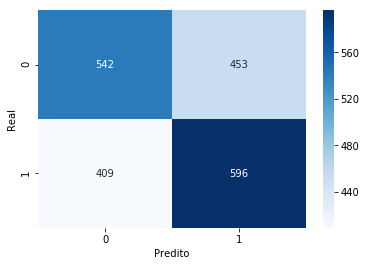

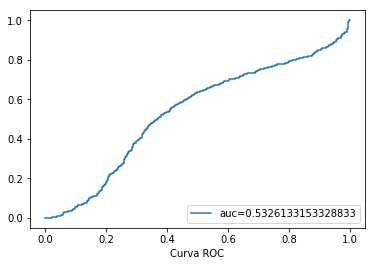

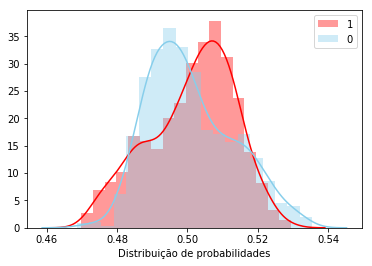

In [18]:
get_results(X_test, y_test, lr)

In [19]:
def plot_FI(model, df):  
    features=df.columns
    importances = model.best_estimator_.feature_importances_ 
    indices = np.argsort(importances)

    plt.figure(figsize=(5, 10))
    plt.title('Importância das variáveis')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('')

In [20]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth': [2,3,4,5],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [10,50,100], 
              'random_state': [33]} 
cv = 3
rf = train_grid_search(X_train, y_train, RandomForestClassifier(), parameters, cv)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   12.8s finished


Melhores parâmetros:

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100, 'random_state': 33}

Tabela com o resultado dos modelos:

0.507 (+/-0.016) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10, 'random_state': 33}
0.511 (+/-0.010) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50, 'random_state': 33}
0.512 (+/-0.012) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100, 'random_state': 33}
0.558 (+/-0.094) for {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 10, 'random_state': 33}
0.555 (+/-0.017) for {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50, 'random_state': 33}
0.560 (+/-0.038) for {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100, 'random_state': 33}
0.578 (+/-0.100) for {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 10, 'random_state': 33}
0.617 (+/-0.072) for {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 50, 'random_state': 33}
0.624 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'n_estim

Accuracy:  0.666

             precision    recall  f1-score   support

        0.0     0.6687    0.6513    0.6599       995
        1.0     0.6634    0.6806    0.6719      1005

avg / total     0.6661    0.6660    0.6659      2000




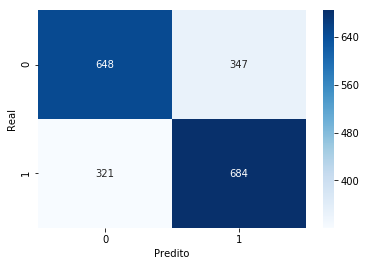

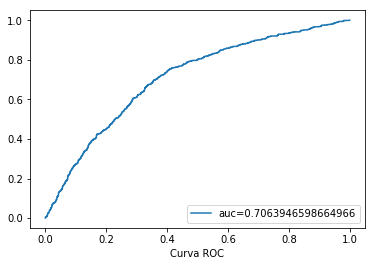

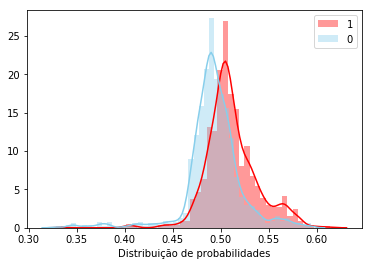

In [21]:
get_results(X_test, y_test, rf)

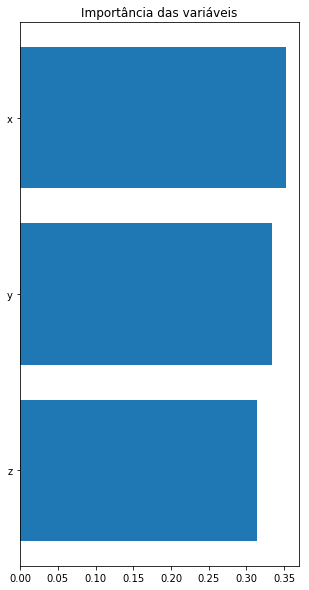

In [22]:
plot_FI(rf, X)

# 4. Feature Engineering 

Dado que o modelo não linear (Ranfom Forest) atingiu um resultado significativamente melhor, pode ser que haja alguma relação entre as variáveis que a modelo linear (Regressão Logística) não tenha conseguido capturar, então será adiconado mais complexidade aos dados com a criação de novas variáveis.

In [23]:
X_new = X

In [24]:
X_new['x*y*z'] = X_new['x'] * X_new['y'] * X_new['z']
X_new['x^2'] = X_new['x']**2
X_new['y^2'] = X_new['y']**2
X_new['z^2'] = X_new['z']**2

In [25]:
X_new.head()

,x,y,z,x*y*z,x^2,y^2,z^2
0,326.488285,188.988808,-312.205307,-1.926389e+07,106594.600151,35716.769471,97472.153414
1,-314.287214,307.276723,-179.037412,1.729021e+07,98776.453005,94418.984584,32054.394994
2,-328.208910,181.627758,446.311062,-2.660543e+07,107721.088643,32988.642297,199193.563710
3,-148.658890,147.027947,-27.477959,6.005861e+05,22099.465649,21617.217259,755.038207
4,-467.065931,250.467651,-306.475330,3.585299e+07,218150.583799,62734.044119,93927.127991


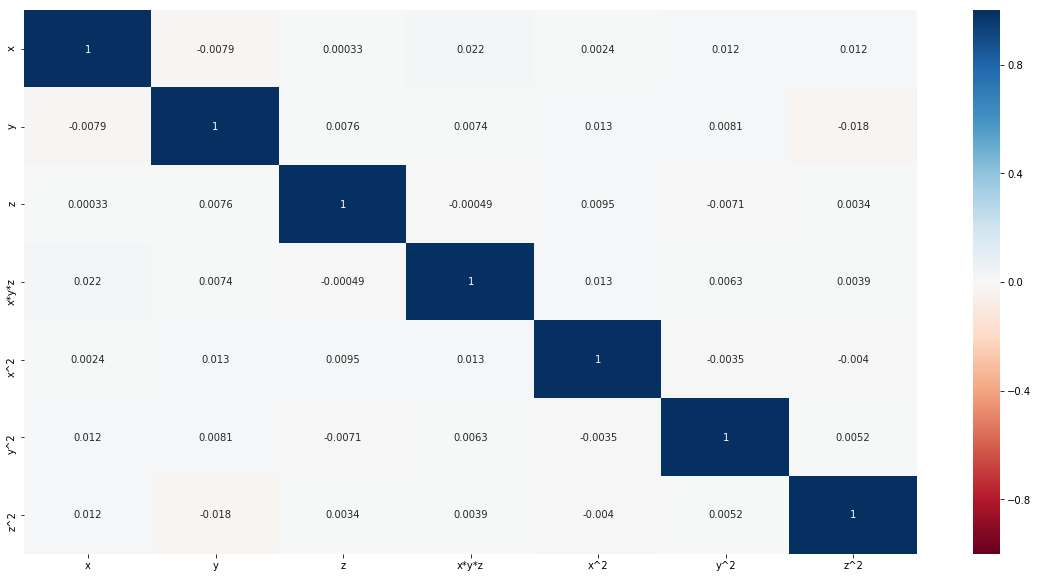

In [26]:
plt.figure(figsize=(20,10))
sns.heatmap(X_new.corr(), vmin=-1, cmap='RdBu', annot=True)

Separando o dataset com as novas variáveis em treino e teste 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, stratify=y, random_state=33)

In [28]:
from sklearn.linear_model import LogisticRegression

parameters = {'solver' : ['newton-cg', 'sag', 'saga', 'liblinear', 'lbfgs'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'random_state': [33]}
cv = 3
lr2 = train_grid_search(X_train, y_train, LogisticRegression(), parameters, cv)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   17.3s finished


Melhores parâmetros:

{'C': 0.001, 'random_state': 33, 'solver': 'saga'}

Tabela com o resultado dos modelos:

0.803 (+/-0.013) for {'C': 0.001, 'random_state': 33, 'solver': 'newton-cg'}
0.809 (+/-0.009) for {'C': 0.001, 'random_state': 33, 'solver': 'sag'}
0.809 (+/-0.009) for {'C': 0.001, 'random_state': 33, 'solver': 'saga'}
0.807 (+/-0.009) for {'C': 0.001, 'random_state': 33, 'solver': 'liblinear'}
0.807 (+/-0.009) for {'C': 0.001, 'random_state': 33, 'solver': 'lbfgs'}
0.803 (+/-0.013) for {'C': 0.01, 'random_state': 33, 'solver': 'newton-cg'}
0.809 (+/-0.009) for {'C': 0.01, 'random_state': 33, 'solver': 'sag'}
0.809 (+/-0.009) for {'C': 0.01, 'random_state': 33, 'solver': 'saga'}
0.807 (+/-0.009) for {'C': 0.01, 'random_state': 33, 'solver': 'liblinear'}
0.807 (+/-0.009) for {'C': 0.01, 'random_state': 33, 'solver': 'lbfgs'}
0.803 (+/-0.013) for {'C': 0.1, 'random_state': 33, 'solver': 'newton-cg'}
0.809 (+/-0.009) for {'C': 0.1, 'random_state': 33, 'solver': 'sag'}
0.809 (+/-

Accuracy:  0.791

             precision    recall  f1-score   support

        0.0     0.7965    0.7789    0.7876       995
        1.0     0.7858    0.8030    0.7943      1005

avg / total     0.7911    0.7910    0.7910      2000




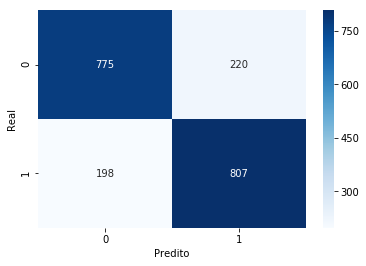

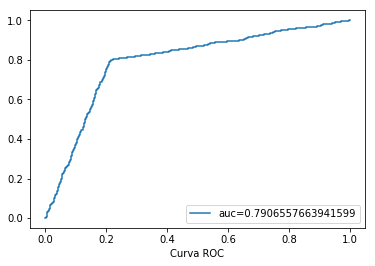

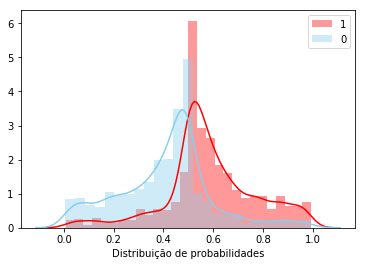

In [29]:
get_results(X_test, y_test, lr2)

In [30]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth': [2,4,5],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [10,50,100], 
              'random_state': [33]} 
cv = 3
rf2 = train_grid_search(X_train, y_train, RandomForestClassifier(), parameters, cv)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   13.8s finished


Melhores parâmetros:

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50, 'random_state': 33}

Tabela com o resultado dos modelos:

0.804 (+/-0.020) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10, 'random_state': 33}
0.808 (+/-0.015) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50, 'random_state': 33}
0.809 (+/-0.014) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100, 'random_state': 33}
0.809 (+/-0.009) for {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 10, 'random_state': 33}
0.810 (+/-0.011) for {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 50, 'random_state': 33}
0.809 (+/-0.014) for {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 33}
0.808 (+/-0.013) for {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10, 'random_state': 33}
0.807 (+/-0.014) for {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50, 'random_state': 33}
0.809 (+/-0.015) for {'criterion': 'gini', 'max_depth': 5, 'n_est

Accuracy:  0.792

             precision    recall  f1-score   support

        0.0     0.7933    0.7869    0.7901       995
        1.0     0.7907    0.7970    0.7939      1005

avg / total     0.7920    0.7920    0.7920      2000




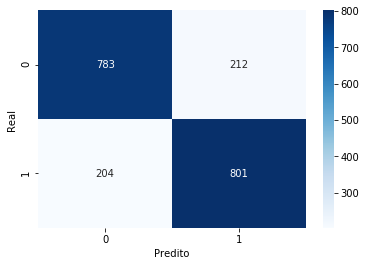

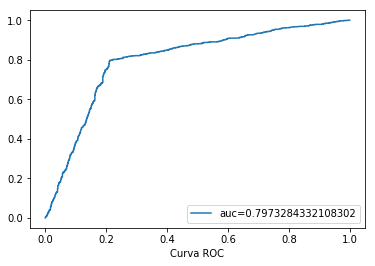

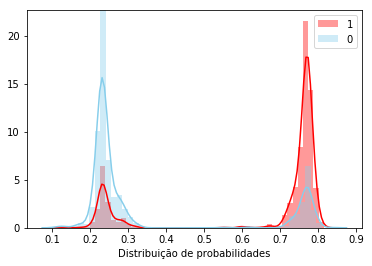

In [31]:
get_results(X_test, y_test, rf2)

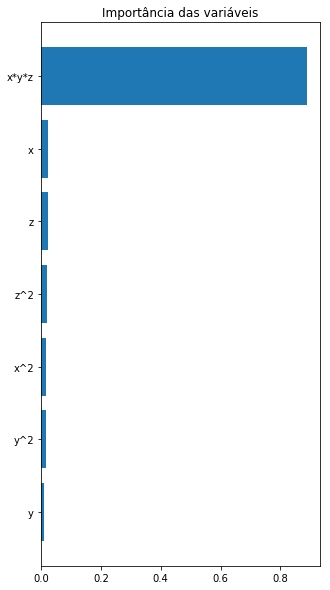

In [32]:
plot_FI(rf2, X_new)

# 5. Conclusão

Podemos observar que a Regressão Logística (RL) teve um desempenho inferior ao Random Forest (RF) com as variáveis originais, mas com as novas variáveis atingiu os mesmos resultados do RF.

Sem a criação de novas variáveis os 2 modelos apresentaram resultados ruins, com acurácia abaixo de 0,67. Após o processo de feature engineering (criação de novas variáveis), a acurácia e a AUC aumentaram significativamente nos 2 modelos, ambos atingiram o mesmo patamar de acurácia ~0,79 e AUC ~0,80.

Entretanto, quando analisamos os gráficos de distribuição de probabilidades da predição das classes, o RF apresenta um nível de "confiança" maior, pois a concentração da distribuição está mais próxima das extremidades (0.25;0.75) e não no meio (0.5) como a RL.

A variável resultante da operação x.y.z se mostrou a mais relevante para a predição das classes, quando analisamos a importância das variáveis no modelo Random Forest.

O processo de feature engineering poderia ser mais explorado com a criação de outras variáveis, devido ao prazo de entrega não foi continuado.
